# Digital signal processing: digital systems

This notebook assumes the basic knowledge of signals and systems from the reader, and focuses on the distinction between continuous-time (CT) and discrete-time (DT) representations of systems.

In [47]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz, butter, freqs, bilinear, dlti, dlsim, lsim, lti, cont2discrete
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

## Continuous time system

We will define a continuous time linear time-invariant system (CT LTI) $h(t)$ to process the signal $x(t)$ by specifying its transfer function $H(s) \triangleq \mathcal{L}(h(t))$, where $\mathcal{L}(.)$ is the Laplace transform operator.

In `scipy.signal` an LTI sytems transfer function can be represented using the coefficients of the denominator $(a)$ and the numerator $(b)$. 

In [48]:
# We define two frequencies which will be used also later in the signal
# generation
low_freq = 5 # Hz
high_freq = 20 # Hz
fs = high_freq * 6 # Hz,  Sampling frequency
T_s = 1/fs # Sampling period

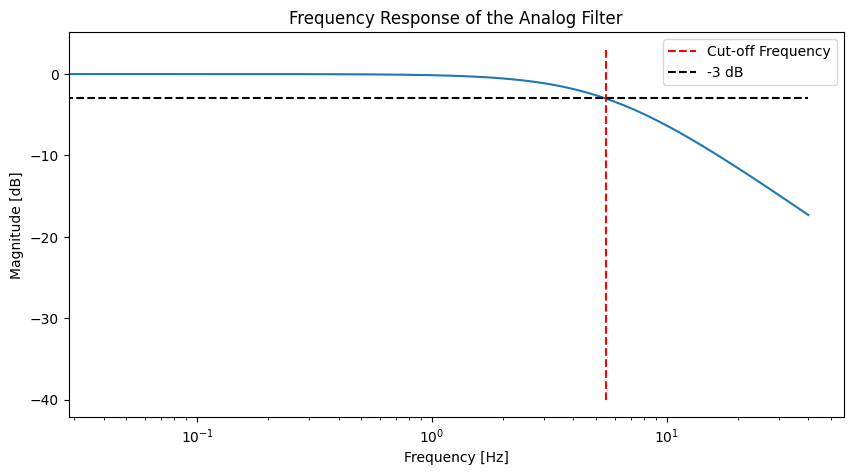

In [49]:
# Define the system by a transfer function (example: simple low-pass filter)
# First order low-pass filter has the transfer function H(s) = w_c / (s + w_c) =
# B(s) / A(s) where w_c is the cut-off frequency in angular frequency (rad/s)
# B(s) = [w_c] * [1]
# A(s) = [1, w_c] * [s, 1]^T
cut_off_hz = low_freq * 1.1  # Cut-off frequency (Hz)
cut_off_angular = (2*np.pi) * cut_off_hz  # Cut-off frequency (rad/s)
a_analog = np.array([1, cut_off_angular])  # denominator
b_analog = np.array([cut_off_angular])     # numerator

# w returns angular frequencies, h returns the frequency response
angular_freqs_to_evaluate = 2*np.pi*np.linspace(0, high_freq*2, 1000)

w_ct, h_ct = freqs(b_analog, a_analog, worN=angular_freqs_to_evaluate)

fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax1.semilogx(w_ct / (2*np.pi) , 20 * np.log10(abs(h_ct)))
ax1.vlines(cut_off_angular/ (2*np.pi), -40, 3, color='r', linestyle='--', label='Cut-off Frequency')
ax1.hlines(-3, 0, high_freq*2, color='k', linestyle='--', label = '-3 dB')
ax1.title.set_text('Frequency Response of the Analog Filter')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Magnitude [dB]')
ax1.legend()
plt.show()

## Discrete time system

Several methods can be used to derive the equivalent discrete-time system from a continuous-time transfer function. The two most commonly used methods are **Impulse Invariance** and **Bilinear Transformation**.

In [50]:
def plot_freq_response_dt(ax_mag, ax_phase, w, h, fs, mag_legend = 'Magnitude Response', phase_legend = 'Phase Response'):
    # Magnitude response
    ax_mag.semilogx(w / (2*np.pi) * fs, 20 * np.log10(abs(h)), label=mag_legend)
    ax_mag.set_xlabel('Frequency [Hz]')
    ax_mag.set_ylabel('Magnitude [dB]')
    ax_mag.legend()
    # Phase response
    ax_phase.plot(w / (2*np.pi) * fs, np.unwrap(np.angle(h)), label=phase_legend)
    ax_phase.set_ylabel('Phase [radians]')
    ax_phase.legend(loc='upper right')
    ax_phase.legend()


### Impulse Invariance

Impulse invariance is a method that preserves the impulse response of the continuous-time system when transitioning to the discrete-time domain. This method involves sampling the continuous-time impulse response $h(t)$ and using those samples as the coefficients for the discrete-time system.

The discrete-time system impulse response is obtained by 
$$
h[n] = h(nT_s)
$$

In [51]:
normalized_freqs_to_evaluate = angular_freqs_to_evaluate / fs # to have the same frequencies returned by freqs() and freqz()

Impulse invariance DT sytem, b= [0.         0.25022291], a = [ 1.         -0.74977709]


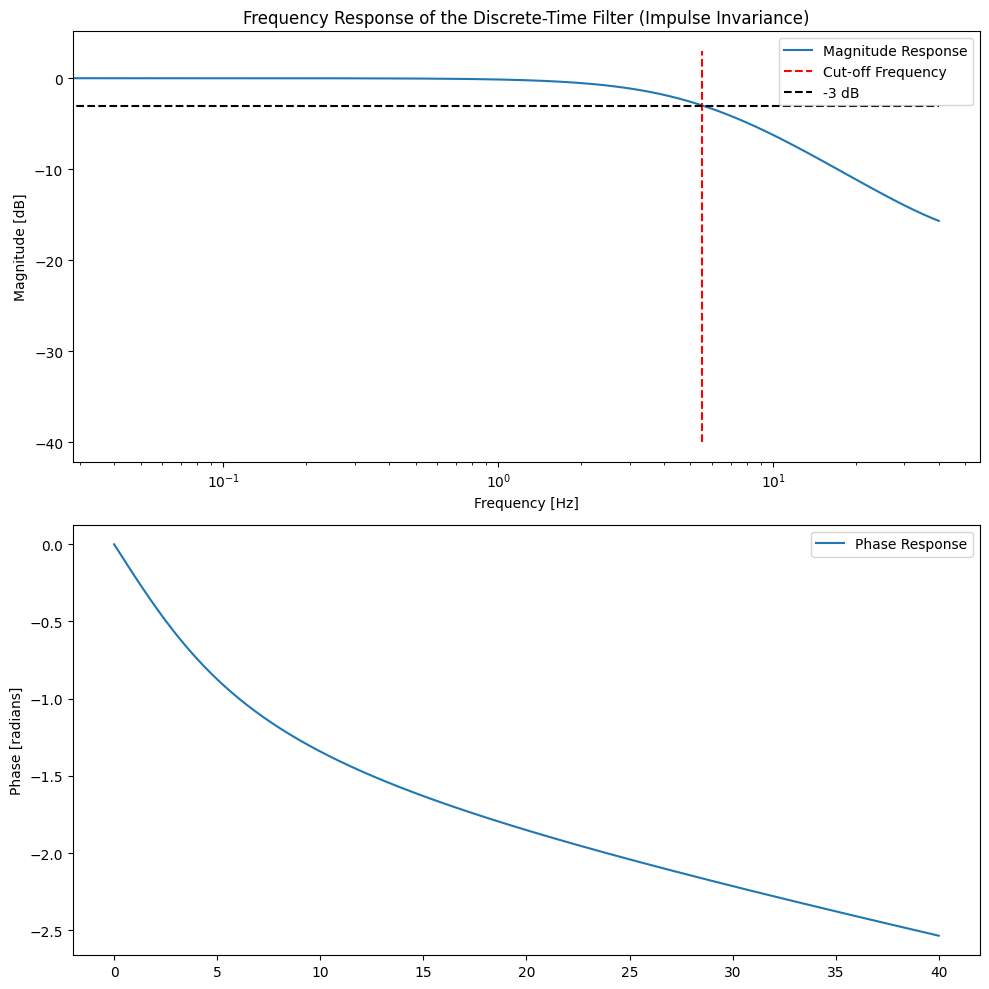

In [52]:
discrete_sys_impulse_invariance = cont2discrete((b_analog, a_analog), T_s, method='zoh')
b_dt_impulse_invariance, a_dt_impulse_invariance = discrete_sys_impulse_invariance[0][0], discrete_sys_impulse_invariance[1]

# Frequency response of the discrete-time system
w_dt_impulse_invariance, h_dt_impulse_invariance = freqz(b_dt_impulse_invariance, a_dt_impulse_invariance, worN=normalized_freqs_to_evaluate)

print(f"Impulse invariance DT sytem, b= {b_dt_impulse_invariance}, a = {a_dt_impulse_invariance}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
plot_freq_response_dt(
    ax_mag=ax1,
    ax_phase=ax2,
    w=w_dt_impulse_invariance,
    h=h_dt_impulse_invariance,
    fs=fs)
ax1.vlines(cut_off_hz, -40, 3, color='r', linestyle='--', label='Cut-off Frequency')
ax1.hlines(-3, 0, high_freq*2, color='k', linestyle='--', label='-3 dB')
ax1.set_title('Frequency Response of the Discrete-Time Filter (Impulse Invariance)')
ax1.legend()
plt.tight_layout()
plt.show()

### Bilinear Transformation

The bilinear transformation method maps the entire $s-$ plane into the $z-$ plane. This allows for direct frequency mapping, preserving the stability of the system and ensuring that the frequency response characteristics are similar. Transform is obtained by substituting:

$$
s = \frac{2}{T_s}\frac{1-z^-1}{1+z^-1}
$$



Then, if the CT transfer function is given as:

$$
H(s) = \frac{b(s)}{a(s)}
$$

the discrete-time transfer function can be expressed as

$$
H(z) = \frac{b(\frac{2}{T_s}\frac{1-z^-1}{1+z^-1})}{a(\frac{2}{T_s}\frac{1-z^-1}{1+z^-1})}
$$

#### Frequency warping effect:
Bilinear transformation maps the entire range of continuous frequencies
$(-\infty, \infty)$ onto the finite discrete-time frequency range $(-\pi,\pi)$ in
the $z-$ domain.

The frequency warping occurs because the bilinear transform compresses higher frequencies more than lower frequencies. This non-uniform scaling means that while low frequencies are mapped almost linearly, high frequencies are "warped" and moved closer to each other. As a result, the frequency response of a system that has undergone bilinear transformation will not match the original system perfectly, particularly at higher frequencies


Bilinear DT sytem, b= [0.12586623 0.12586623], a = [ 1.         -0.74826754]


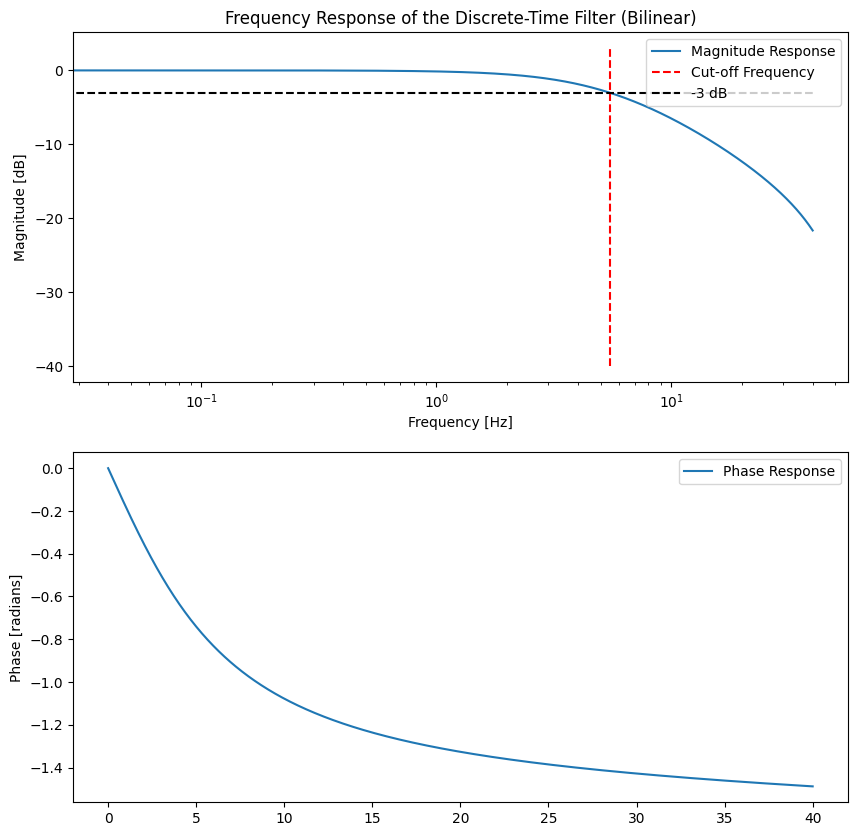

In [53]:
# Bilinear transformation to get digital filter coefficients
b_dt_bilinear, a_dt_bilinear = bilinear(b_analog, a_analog, fs=fs)

coeff_ct_to_dt = (2*np.pi)/fs

# w returns normalized frequencies, h returns the frequency response

w_dt, h_dt = freqz(b_dt_bilinear, a_dt_bilinear, worN=normalized_freqs_to_evaluate)

print(f"Bilinear DT sytem, b= {b_dt_bilinear}, a = {a_dt_bilinear}")

fig,(ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
plot_freq_response_dt(
    ax_mag=ax1,
    ax_phase=ax2,
    w=w_dt,
    h=h_dt,
    fs=fs)
ax1.vlines(cut_off_hz, -40, 3, color='r', linestyle='--', label='Cut-off Frequency')
ax1.hlines(-3, 0, high_freq*2, color='k', linestyle='--', label='-3 dB')
ax1.set_title('Frequency Response of the Discrete-Time Filter (Bilinear)')
ax1.legend()
plt.show()




Let's also plot the effect of frequency warping and see the discrepancies in the higher frequencies

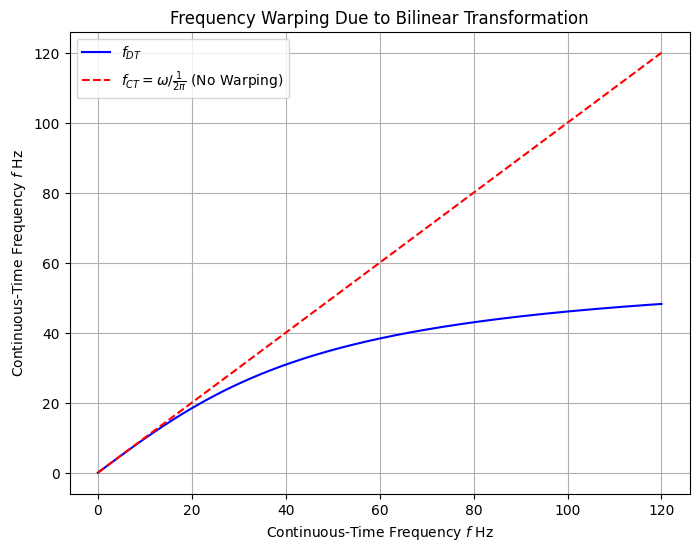

In [54]:
# Define continuous-time frequencies (omega)
omega = np.linspace(0, 2 * np.pi * fs, 1000)  # Continuous-time frequency (angular)

# Compute discrete-time frequencies (Omega) using the bilinear transformation formula
Omega = 2 * np.arctan(omega * T_s / 2)

# Plot the frequency warping ( mapping it back to frequency in Hz)
plt.figure(figsize=(8, 6))
plt.plot(omega /( 2 * np.pi ) , Omega * fs / ( 2 * np.pi ), label=r'$f_{DT} $', color='b')
plt.plot(omega / ( 2 * np.pi ), omega / ( 2 * np.pi ), '--', label=r'$f_{CT} = \omega / \frac{1}{2\pi}$ (No Warping)', color='r')  # Ideal linear relationship

plt.title('Frequency Warping Due to Bilinear Transformation')
plt.xlabel('Continuous-Time Frequency $f$ Hz')
plt.ylabel('Continuous-Time Frequency $f$ Hz')
plt.grid(True)
plt.legend()
plt.show()


## Comparing CT and equivalent DT systems

### Frequency responses
First comparison between the original CT system and the discretized DT system is to compare the frequency responses.

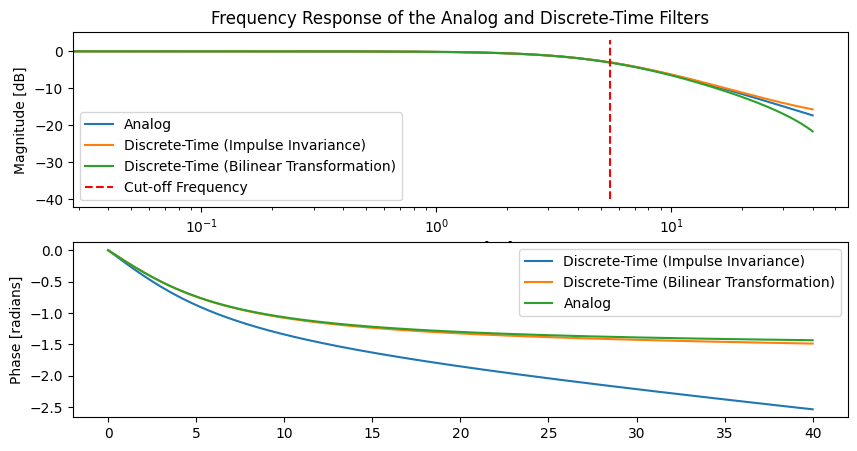

In [55]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))

ax1.semilogx(w_ct / (2*np.pi), 20 * np.log10(abs(h_ct)), linestyle='-', label='Analog' )
plot_freq_response_dt(ax_mag=ax1, ax_phase=ax2, w=w_dt_impulse_invariance, h=h_dt_impulse_invariance, fs=fs, mag_legend='Discrete-Time (Impulse Invariance)', phase_legend='Discrete-Time (Impulse Invariance)')
plot_freq_response_dt(ax_mag=ax1, ax_phase=ax2, w=w_dt, h=h_dt, fs=fs, mag_legend='Discrete-Time (Bilinear Transformation)', phase_legend='Discrete-Time (Bilinear Transformation)')

ax1.vlines(cut_off_hz, -40, 3, color='r', linestyle='--', label='Cut-off Frequency')
ax1.title.set_text('Frequency Response of the Analog and Discrete-Time Filters')

ax2.plot(w_ct / (2*np.pi), np.unwrap(np.angle(h_ct)), linestyle='-', label='Analog')
ax2.legend()
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Magnitude [dB]')
ax1.legend()
plt.show()

### Response to an sinosoidal signal

We will pass a signal through them and inspect the output signal from the CT system and also the DT systems

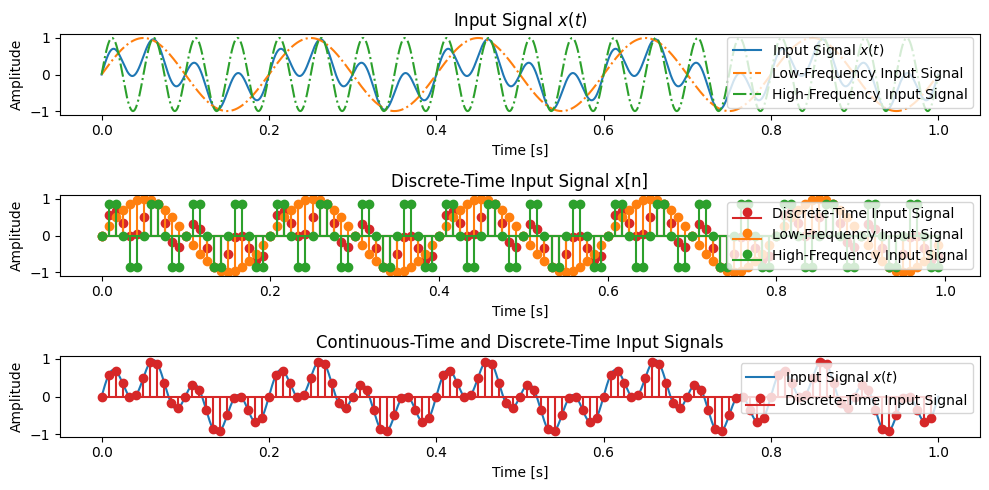

In [56]:
# We simulate `continuous-time` signal by using a high sampling frequency and
# `discrete time` signal by using a lower sampling frequency
ct_dt_ratio = 200
fs_ct = fs * ct_dt_ratio

# Define the time vector
t_ct = np.linspace(0, 1, fs_ct, endpoint=False)
t_dt = np.linspace(0, 1, fs, endpoint=False)

low_freq_signal_ct = np.sin(2 * np.pi * low_freq * t_ct)
high_freq_signal_ct = np.sin(2 * np.pi * high_freq * t_ct)
input_signal_ct = 0.5 * low_freq_signal_ct + 0.5 * high_freq_signal_ct

# Create DT signal (sampled from CT signal)
low_freq_signal_dt = low_freq_signal_ct[::ct_dt_ratio]
high_freq_signal_dt = high_freq_signal_ct[::ct_dt_ratio]
input_signal_dt = input_signal_ct[::ct_dt_ratio]
t_dt = t_ct[::ct_dt_ratio]


fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(10, 5))
# Plot input signal
ax1.plot(t_ct, input_signal_ct, label=r'Input Signal $x(t)$')
ax1.plot(t_ct, low_freq_signal_ct, label='Low-Frequency Input Signal', linestyle='-.')
ax1.plot(t_ct, high_freq_signal_ct, label='High-Frequency Input Signal', linestyle='-.')
ax1.legend()
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Amplitude')
ax1.title.set_text(r'Input Signal $x(t)$')

# Plot discrete-time signal
ax2.stem(t_dt, input_signal_dt, linefmt='C3-', markerfmt='C3o', basefmt='C3-', label='Discrete-Time Input Signal')
ax2.stem(t_dt, low_freq_signal_dt, linefmt='C1-', markerfmt='C1o', basefmt='C1-', label='Low-Frequency Input Signal')
ax2.stem(t_dt, high_freq_signal_dt, linefmt='C2-', markerfmt='C2o', basefmt='C2-', label='High-Frequency Input Signal')
ax2.legend()
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Amplitude')
ax2.title.set_text(r'Discrete-Time Input Signal x[n]')

# Plot ct and dt signals
ax3.plot(t_ct, input_signal_ct, label=r'Input Signal $x(t)$')
ax3.stem(t_dt, input_signal_dt, linefmt='C3-', markerfmt='C3o', basefmt='C3-', label='Discrete-Time Input Signal')
ax3.legend()
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Amplitude')
ax3.title.set_text(r'Continuous-Time and Discrete-Time Input Signals')

plt.tight_layout()
plt.show()


Now both the CT signal $x(t)$ and DT signal $x[n]$ is created, we can compare the outputs from CT and DT systems

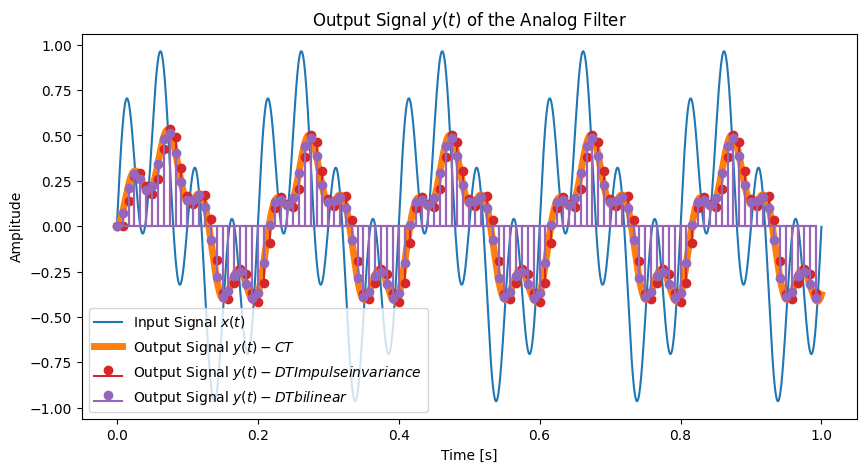

In [61]:
# Create the analog CT system
system_analog = lti(b_analog, a_analog)

system_dt_impulse_invariance = dlti(b_dt_impulse_invariance, a_dt_impulse_invariance, dt=1/fs)

system_dt_bilinear = dlti(b_dt_bilinear, a_dt_bilinear, dt=1/fs)

# Get the response of the analog system to the input signal
t_out_analog, y_out_analog, _ = lsim(system_analog, input_signal_ct, t_ct)

# get the response of the discrete-time system to the input signal
t_out_dt_impulse_invariance, y_out_dt_impulse_invariance = dlsim(system_dt_impulse_invariance, input_signal_dt)
t_out_dt_bilinear, y_out_dt_bilinear = dlsim(system_dt_bilinear, input_signal_dt)

# Plot the output signal
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax1.plot(t_ct, input_signal_ct, label=r'Input Signal $x(t)$')
ax1.plot(t_out_analog, y_out_analog, linewidth =5, label=r'Output Signal $y(t) - CT$')
ax1.stem(t_out_dt_impulse_invariance, y_out_dt_impulse_invariance, linefmt='C3-', markerfmt='C3o', basefmt='C3-', label=r'Output Signal $y(t) - DT Impulse invariance$')
ax1.stem(t_out_dt_bilinear, y_out_dt_bilinear, linefmt='C4-', markerfmt='C4o', basefmt='C4-', label=r'Output Signal $y(t) - DT bilinear $')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Amplitude')
ax1.legend()
ax1.title.set_text(r'Output Signal $y(t)$ of the Analog Filter')
plt.show()


As expected, the outputs of the DT systems are consistent wit the output of the CT system